# **Casos confirmados de COVID-19 en Bogotá D.C.**

**Exploratory Data Analysis Project by Carlos Alberto Cortés Ramírez**

Permite conocer la evolución del número de casos confirmados con nuevo coronavirus COVID-19 en el contexto de la pandemia.

Secretaría Distrital de Salud.

https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c/resource/b64ba3c4-9e41-41b8-b3fd-2da21d627558

# **Importando Datos**

Se intentó importar datos vía API, sin embargo se detectaron varios errores en la documentación y los links solo daban de a 100 registros, lo cual hace la tarea muy ineficiente. Por lo cual se hará descargando el archivo .csv. De manera anecdotica se deja como sería sacar los datos desde la API




```python
url = 'https://datosabiertos.bogota.gov.co/api/3/action/datastore_search?resource_id=b64ba3c4-9e41-41b8-b3fd-2da21d627558'  
fileobj = urllib.request.urlopen(url)
data = fileobj.read().decode('utf-8')
parsed_data = json.loads(data)
df = pd.DataFrame(parsed_data["result"]["records"])
next_records = parsed_data["result"]["_links"]["next"]

urllib.request.urlopen('https://datosabiertos.bogota.gov.co'+next_records)
```



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import scipy.stats as ss
import geopandas as gpd

Familiarizandose con la Data

In [2]:

df = pd.read_csv('osb_enftransm-covid-19_20230329.csv', encoding = 'utf-8',  sep=',')

# There is a error trying to import the data in a default way
# ParserError: Error tokenizing data. C error: Expected 1 fields in line 845266, saw 3
# the default separator

In [3]:
df.head()

,CASO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-02-26,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-04,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-07,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-06,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-06,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


In [4]:
df.shape

(1876297, 11)

In [5]:
df.columns

Index(['CASO', 'FECHA_DE_INICIO_DE_SINTOMAS', 'FECHA_DIAGNOSTICO', 'CIUDAD',
       'LOCALIDAD_ASIS', 'EDAD', 'UNI_MED', 'SEXO',
       'FUENTE_O_TIPO_DE_CONTAGIO', 'UBICACION', 'ESTADO'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876297 entries, 0 to 1876296
Data columns (total 11 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   CASO                         int64 
 1   FECHA_DE_INICIO_DE_SINTOMAS  object
 2   FECHA_DIAGNOSTICO            object
 3   CIUDAD                       object
 4   LOCALIDAD_ASIS               object
 5   EDAD                         int64 
 6   UNI_MED                      int64 
 7   SEXO                         object
 8   FUENTE_O_TIPO_DE_CONTAGIO    object
 9   UBICACION                    object
 10  ESTADO                       object
dtypes: int64(3), object(8)
memory usage: 157.5+ MB


In [7]:
df.describe()

,CASO,EDAD,UNI_MED
count,1.876297e+06,1.876297e+06,1.876297e+06
mean,9.381490e+05,3.920477e+01,1.005343e+00
std,5.416404e+05,1.821313e+01,7.754102e-02
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.690750e+05,2.600000e+01,1.000000e+00
50%,9.381490e+05,3.700000e+01,1.000000e+00
75%,1.407223e+06,5.200000e+01,1.000000e+00
max,1.876297e+06,1.190000e+02,3.000000e+00


# **Data Cleaning**

In [8]:
df[df.columns]

,CASO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-02-26,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-04,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-07,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-06,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-06,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado
...,...,...,...,...,...,...,...,...,...,...,...
1876292,1876293,NaN,2023-03-25,Sin dato,Sin dato,34,1,F,Comunitaria,Casa,Leve
1876293,1876294,NaN,2023-03-25,Sin dato,Sin dato,58,1,F,Comunitaria,Casa,Leve
1876294,1876295,NaN,2023-03-25,Sin dato,Sin dato,82,1,F,Comunitaria,Casa,Leve
1876295,1876296,NaN,2023-03-25,Sin dato,Sin dato,58,1,F,Comunitaria,Casa,Leve


In [9]:
df.isna().sum(axis=0)/len(df)

CASO                           0.000000
FECHA_DE_INICIO_DE_SINTOMAS    0.254578
FECHA_DIAGNOSTICO              0.000000
CIUDAD                         0.000000
LOCALIDAD_ASIS                 0.000000
EDAD                           0.000000
UNI_MED                        0.000000
SEXO                           0.000000
FUENTE_O_TIPO_DE_CONTAGIO      0.000000
UBICACION                      0.000000
ESTADO                         0.000000
dtype: float64

# Descartando columna de fecha de inicio de sintomas

Esta columna tiene mas de un 25% de datos faltantes, además no se considera muy relevante para el analisis, por lo cual se decide descartar

In [10]:
df = df.drop('FECHA_DE_INICIO_DE_SINTOMAS',axis=1)

In [11]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


# **Data Exploration**

**plt.hist description**

This method uses numpy.histogram to bin the data in **x** and **count the number of values in each bin, then draws the distribution** either as a BarContainer or Polygon. The bins, range, density, and weights parameters are forwarded to numpy.histogram.

In [69]:
bins = np.arange(0,105, 5)
bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

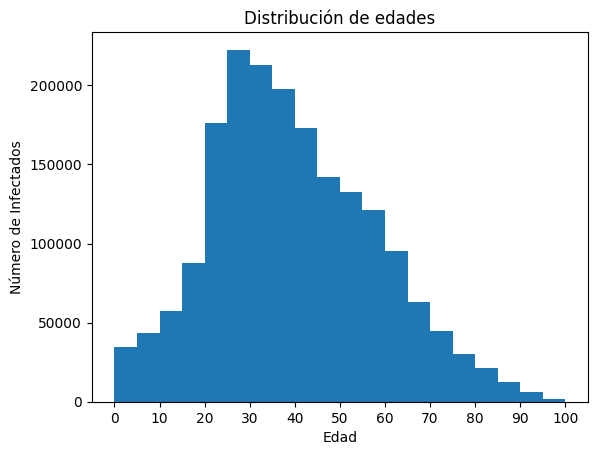

In [72]:
fig, ax = plt.subplots()
ax.hist(df['EDAD'], bins=bins)

# set the x and y axis tick marks
ax.set_xticks(np.arange(0,105, 10))

ax.set_xlabel('Edad')
ax.set_ylabel('Número de Infectados')
ax.set_title('Distribución de edades')

plt.show()

# **Mapa de Bogotá**

<Axes: >

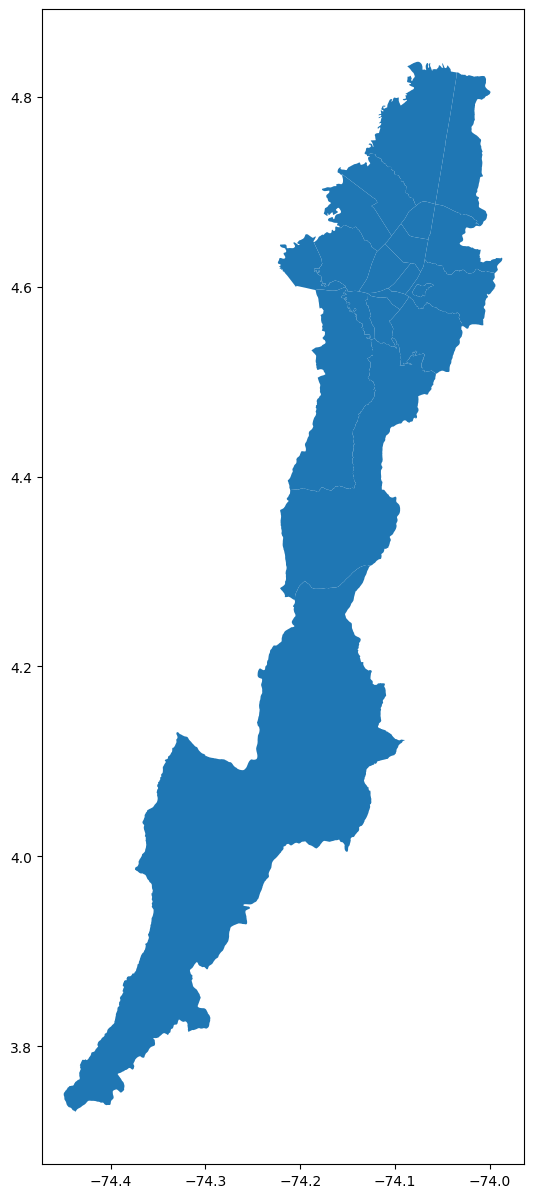

In [13]:
# Crea un objeto GeoDataFrame de GeoPandas
bog_map = gpd.read_file('poligonos-localidades.geojson')
bog_map.plot(figsize=(30,15))

In [14]:
bog_map.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry
0,ANTONIO NARIÑO,Acuerdo 117 de 2003,"4879543,386426",15,"{'lon': -74.10284240061449, 'lat': 4.588770674...","MULTIPOLYGON (((-74.13075 4.59335, -74.13075 4..."
1,TEUSAQUILLO,Acuerdo 8 de 1977,"14193168,127546",13,"{'lon': -74.08576901958143, 'lat': 4.641173586...","MULTIPOLYGON (((-74.09372 4.66607, -74.10342 4..."
2,SUMAPAZ,Acuerdo 9 de 1986,"780968757,719072",20,"{'lon': -74.25697871800469, 'lat': 4.036568747...","MULTIPOLYGON (((-74.20584 4.26966, -74.20567 4..."
3,SAN CRISTOBAL,Acuerdo 117 de 2003,"49098548,52917",04,"{'lon': -74.06607256050648, 'lat': 4.548749008...","MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4..."
4,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4..."


In [15]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


# Transformar columna localidad
Debemos pasarlo a mayusculas y quitarle las tildes para que coincida con la del mapa

# Descartar Sumapaz

Como sumapaz cuenta con tan pocos casos se decide descartarla del conteo, aproximadamente contaba con 152 comparada con cientos de miles en las otras localidades

In [16]:
bog_map = bog_map[bog_map['Nombre de la localidad'] != 'SUMAPAZ']

In [17]:
df_localidades = df.groupby('LOCALIDAD_ASIS').count()
df_localidades

,CASO,FECHA_DIAGNOSTICO,CIUDAD,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
LOCALIDAD_ASIS,,,,,,,,,
Antonio Nariño,24189,24189,24189,24189,24189,24189,24189,24189,24189
Barrios Unidos,43602,43602,43602,43602,43602,43602,43602,43602,43602
Bosa,125162,125162,125162,125162,125162,125162,125162,125162,125162
Chapinero,63262,63262,63262,63262,63262,63262,63262,63262,63262
Ciudad Bolívar,101137,101137,101137,101137,101137,101137,101137,101137,101137
Engativá,205220,205220,205220,205220,205220,205220,205220,205220,205220
Fontibón,97605,97605,97605,97605,97605,97605,97605,97605,97605
Fuera de Bogotá,32003,32003,32003,32003,32003,32003,32003,32003,32003
Kennedy,225084,225084,225084,225084,225084,225084,225084,225084,225084


In [18]:
import unicodedata
# Función generada por chatGPT para omitir tildes
def quitar_tildes(texto):
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = texto_normalizado.encode('ASCII', 'ignore').decode('utf-8')
    return texto_sin_tildes

In [19]:
df_localidades.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
LOCALIDAD_ASIS,,,,,,,,,
Antonio Nariño,24189,24189,24189,24189,24189,24189,24189,24189,24189
Barrios Unidos,43602,43602,43602,43602,43602,43602,43602,43602,43602
Bosa,125162,125162,125162,125162,125162,125162,125162,125162,125162
Chapinero,63262,63262,63262,63262,63262,63262,63262,63262,63262
Ciudad Bolívar,101137,101137,101137,101137,101137,101137,101137,101137,101137


In [20]:
df_localidades.index.map(lambda x:quitar_tildes(x.upper()))

Index(['ANTONIO NARINO', 'BARRIOS UNIDOS', 'BOSA', 'CHAPINERO',
       'CIUDAD BOLIVAR', 'ENGATIVA', 'FONTIBON', 'FUERA DE BOGOTA', 'KENNEDY',
       'LA CANDELARIA', 'LOS MARTIRES', 'PUENTE ARANDA', 'RAFAEL URIBE URIBE',
       'SAN CRISTOBAL', 'SANTA FE', 'SIN DATO', 'SUBA', 'SUMAPAZ',
       'TEUSAQUILLO', 'TUNJUELITO', 'USAQUEN', 'USME'],
      dtype='object', name='LOCALIDAD_ASIS')

In [21]:
df_localidades.index = df_localidades.index.map(lambda x:quitar_tildes(x.upper()))
df_localidades = df_localidades['CASO'] # nos podemos quedar con solo una columna porque hicimos un .count por lo tanto todas las columnas tendran el mismo valor
df_localidades

LOCALIDAD_ASIS
ANTONIO NARINO         24189
BARRIOS UNIDOS         43602
BOSA                  125162
CHAPINERO              63262
CIUDAD BOLIVAR        101137
ENGATIVA              205220
FONTIBON               97605
FUERA DE BOGOTA        32003
KENNEDY               225084
LA CANDELARIA          10258
LOS MARTIRES           23859
PUENTE ARANDA          67952
RAFAEL URIBE URIBE     81256
SAN CRISTOBAL          70068
SANTA FE               32845
SIN DATO               64844
SUBA                  290585
SUMAPAZ                  151
TEUSAQUILLO            54761
TUNJUELITO             38740
USAQUEN               164918
USME                   58796
Name: CASO, dtype: int64

In [22]:
casos_por_localidad = bog_map.merge(df_localidades, left_on='Nombre de la localidad',right_on='LOCALIDAD_ASIS')
casos_por_localidad.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry,CASO
0,TEUSAQUILLO,Acuerdo 8 de 1977,"14193168,127546",13,"{'lon': -74.08576901958143, 'lat': 4.641173586...","MULTIPOLYGON (((-74.09372 4.66607, -74.10342 4...",54761
1,SAN CRISTOBAL,Acuerdo 117 de 2003,"49098548,52917",04,"{'lon': -74.06607256050648, 'lat': 4.548749008...","MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4...",70068
2,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4...",164918
3,TUNJUELITO,Acuerdo 117 de 2003,"9910939,743524",06,"{'lon': -74.13598945142014, 'lat': 4.574841398...","MULTIPOLYGON (((-74.13777 4.59489, -74.14043 4...",38740
4,BOSA,Acuerdo 14 de 1983,"23933196,086856",07,"{'lon': -74.19438893446508, 'lat': 4.621779959...","MULTIPOLYGON (((-74.18567 4.64705, -74.18568 4...",125162


In [23]:
casos_por_localidad  = casos_por_localidad.sort_values(by ='CASO',ascending=False)
casos_por_localidad.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry,CASO
12,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4...",290585
14,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4...",225084
9,ENGATIVA,Acuerdo 8 de 1977,"35880967,349154",10,"{'lon': -74.113187703298, 'lat': 4.70112556327...","MULTIPOLYGON (((-74.15547 4.71798, -74.15547 4...",205220
2,USAQUEN,Acuerdo 8 de 1977,"65315721,646621",01,"{'lon': -74.02782483459404, 'lat': 4.742092413...","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4...",164918
4,BOSA,Acuerdo 14 de 1983,"23933196,086856",07,"{'lon': -74.19438893446508, 'lat': 4.621779959...","MULTIPOLYGON (((-74.18567 4.64705, -74.18568 4...",125162


<Axes: title={'center': 'Distribución Casos COVID-19 por localidades'}>

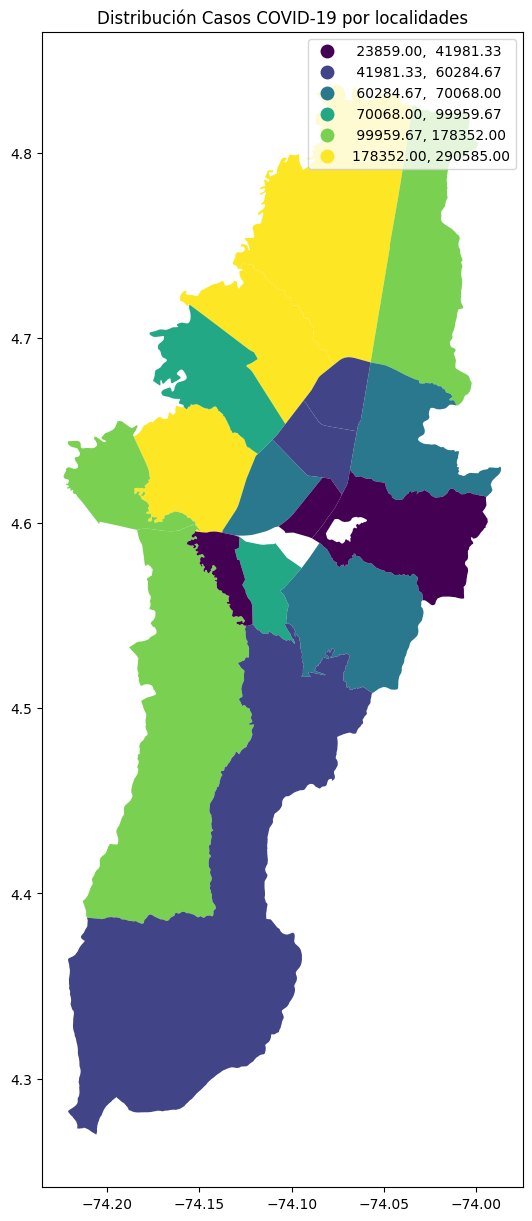

In [24]:
ax = casos_por_localidad.plot(column='CASO', scheme='QUANTILES',k=6,legend=True,figsize=(30,15))
ax.set_title('Distribución Casos COVID-19 por localidades')
ax

# Diagrama de Barras 

In [100]:
mask = (df_localidades.index != 'SUMAPAZ') & (df_localidades.index != 'SIN DATO') & (df_localidades.index != 'FUERA DE BOGOTA')
df_localidades = df_localidades[mask]

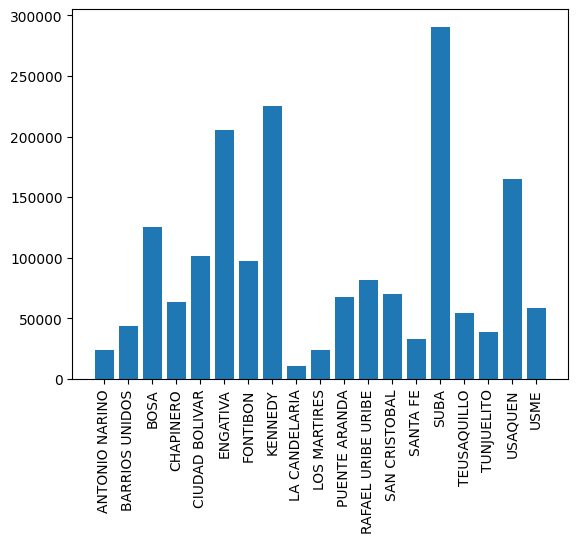

In [103]:
plt.bar(df_localidades.index,df_localidades)
plt.xticks(rotation=90)
plt.show()

# Casos con el tiempo

In [25]:
df.head()

,CASO,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


In [26]:
df_by_date = df.groupby('FECHA_DIAGNOSTICO').agg(["count"])

In [57]:
df_by_date.head()

,CASO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
,count,count,count,count,count,count,count,count,count
FECHA_DIAGNOSTICO,,,,,,,,,
2020-03-06,1,1,1,1,1,1,1,1,1
2020-03-10,2,2,2,2,2,2,2,2,2
2020-03-12,2,2,2,2,2,2,2,2,2
2020-03-13,6,6,6,6,6,6,6,6,6
2020-03-14,4,4,4,4,4,4,4,4,4


# Pasar columna fecha a tipo fecha

In [27]:
from datetime import datetime
df_by_date.index = df_by_date.index.map(lambda x:datetime.strptime(x, '%Y-%m-%d') )

# Graficar

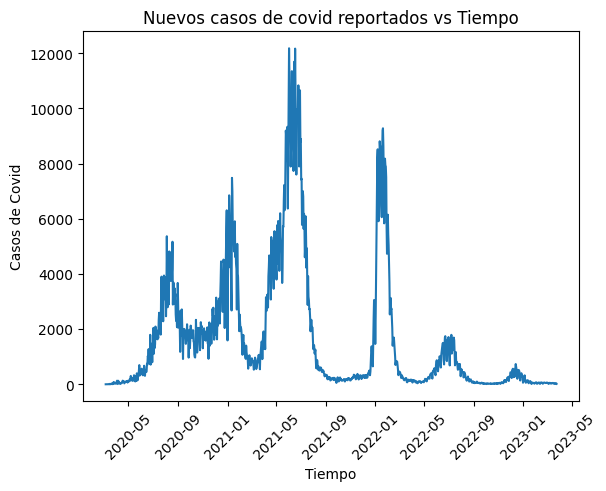

In [73]:
fig, ax = plt.subplots()
plt.xlabel('Tiempo')
plt.ylabel('Casos de Covid')
plt.title('Nuevos casos de covid reportados vs Tiempo')
plt.xticks(rotation=45)
plt.plot(df_by_date.index,df_by_date['CASO'])
#plt.bar(df_by_date.index,df_by_date['CASO'])
plt.show()

# Graficas variables cualitativas

Vamos a explorar las variables cualitativas con distintas graficas que nos permitan entender los fenomenos del COVID en Bogotá

**Sexo**

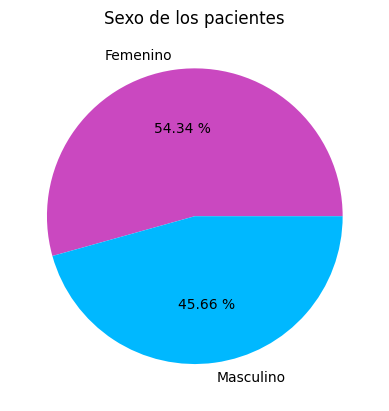

In [85]:
left = df[df['SEXO'] == 'F'].count()[0]
right = df[df['SEXO'] == 'M'].count()[0]

labels = ['Femenino', 'Masculino']
colors = ['#ca48c0','#00b8ff']
plt.pie([left,right], labels = labels, colors=colors, autopct='%.2f %%')
plt.title('Sexo de los pacientes')
plt.show()

**Fuente o tipo de contagio**

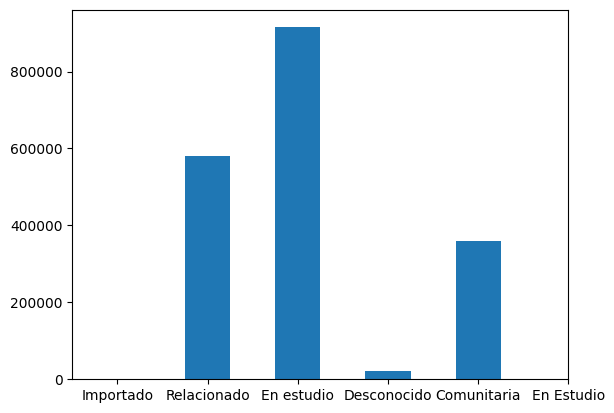

In [113]:
plt.hist(df['FUENTE_O_TIPO_DE_CONTAGIO'],align='left')
plt.show()